In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [2]:
import ktrain
from ktrain import text

/home/umbra/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DATA_PATH = './datasets/combined_v1.1.csv'
MAXLEN = 500
trn, val, preproc = text.texts_from_csv(DATA_PATH,
                     'TEXT',
                      label_columns = ['Computer Science' , 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance', 'Geodesy', 'Geology', 'Neftegas'],
                      val_filepath=None, # if None, 10% of data will be used for validation
                      maxlen=MAXLEN,
                      preprocess_mode='distilbert',
                      ngram_range=1)

detected encoding: utf-8 (if wrong, set manually)
['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance', 'Geodesy', 'Geology', 'Neftegas']
       Computer Science  Physics  Mathematics  Statistics  \
746                   1        0            0           0   
6385                  0        0            0           0   
11545                 0        1            0           0   
19606                 0        1            0           0   
18934                 1        0            0           0   

       Quantitative Biology  Quantitative Finance  Geodesy  Geology  Neftegas  
746                       0                     0        0        0         0  
6385                      0                     1        0        0         0  
11545                     0                     0        0        0         0  
19606                     0                     0        0        0         0  
18934                     0             

Is Multi-Label? True
preprocessing test...
language: en
test sequence lengths:
	mean : 152
	95percentile : 259
	99percentile : 296


In [5]:
model = text.text_classifier('distilbert', trn , preproc=preproc)

Is Multi-Label? True
maxlen is 500
done.


In [6]:
learner = ktrain.get_learner(model, 
                             train_data=trn, 
                             val_data=val, 
                             batch_size=6)

In [7]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
3174/3174 [==============================] - 394s 121ms/step - loss: 1707.2828 - binary_accuracy: 0.8660


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 7.55E-05
	Min numerical gradient (purple): 1.55E-05
	Min loss divided by 10 (omitted from plot): 4.86E-03


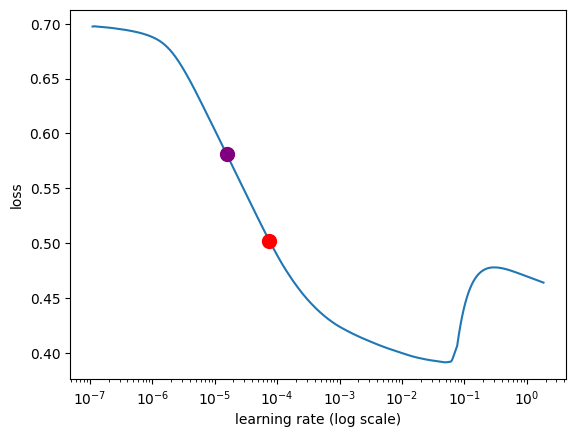

In [8]:
learner.lr_plot(suggest=True)

In [9]:
# 2e-5 is one of the LRs  recommended by Google and is consistent with the plot above.
learner.fit_onecycle(1.55E-05, 3)



begin training using onecycle policy with max lr of 1.55e-05...
Epoch 1/3
3175/3175 [==============================] - 756s 236ms/step - loss: 0.1956 - accuracy: 0.7278 - val_loss: 0.1308 - val_accuracy: 0.7685
Epoch 2/3
3175/3175 [==============================] - 751s 236ms/step - loss: 0.1153 - accuracy: 0.7744 - val_loss: 0.1155 - val_accuracy: 0.7539
Epoch 3/3
3175/3175 [==============================] - 749s 236ms/step - loss: 0.0889 - accuracy: 0.8043 - val_loss: 0.1148 - val_accuracy: 0.7482


In [10]:
learner.evaluate()

67/67 [==============================] - 25s 363ms/step
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       879
           1       0.90      0.86      0.88       587
           2       0.85      0.81      0.83       561
           3       0.76      0.77      0.76       535
           4       0.73      0.53      0.62        77
           5       0.82      0.58      0.68        24
           6       1.00      0.25      0.40         4
           7       1.00      0.33      0.50         6
           8       1.00      1.00      1.00         5

   micro avg       0.83      0.82      0.83      2678
   macro avg       0.88      0.67      0.72      2678
weighted avg       0.83      0.82      0.83      2678
 samples avg       0.85      0.86      0.83      2678



/home/umbra/.local/lib/python3.10/site-packages/ktrain/core.py:226: UserWarning: Confusion matrices do not currently support multilabel classification, so returning None
  warnings.warn(


predictions

In [11]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [12]:
data = [ 'Maxwell equations (the so called stochastic MLLG system) describes the creation of domain walls and vortices (fundamental objects for the novel nanostructured magnetic memories). We first reformulate the stochastic LLG equation into an equation with time-differentiable solutions. We then propose a convergent $\theta$-linear scheme to approximate the solutions of the reformulated system. As a consequence, we prove convergence of the approximate solutions, with no or minor conditions on time and space steps (depending on the value of $\theta$). Hence, we prove the existence of weak martingale solutions of the stochastic  MLLG system. Numerical results are presented to show applicability of the ethod.']

In [13]:
predictor.predict(data)

[[('Computer Science', 0.078553006),
  ('Physics', 0.24801277),
  ('Mathematics', 0.92527044),
  ('Statistics', 0.005351793),
  ('Quantitative Biology', 0.0019710483),
  ('Quantitative Finance', 0.00071376027),
  ('Geodesy', 0.00022365741),
  ('Geology', 0.00015908504),
  ('Neftegas', 0.00017356548)]]

['geodesy', 'geology', 'math', 'neftegas_texts']

In [14]:
predictor.predict(data, return_proba=True)

array([[7.8553006e-02, 2.4801277e-01, 9.2527044e-01, 5.3517930e-03,
        1.9710483e-03, 7.1376027e-04, 2.2365741e-04, 1.5908504e-04,
        1.7356548e-04]], dtype=float32)

In [15]:
predictor.save('./trained_models/topics_predictor_v3.2')